In [15]:
"""Function definitions that are used in JPEG LSB steganography."""
from scipy.fftpack import dct
from scipy.fftpack import idct
from PIL import Image



"""Function definitions that are used in LSB steganography."""
from matplotlib import pyplot as plt
import numpy as np
import binascii
import cv2 as cv
import math
plt.rcParams["figure.figsize"] = (18,10)


def encode_as_binary_array(msg):
    """Encode a message as a binary string."""
    msg = msg.encode("utf-8")
    msg = msg.hex()
    msg = [msg[i:i + 2] for i in range(0, len(msg), 2)]
    msg = [ "{:08b}".format(int(el, base=16)) for el in msg]
    return "".join(msg)


def decode_from_binary_array(array):
    """Decode a binary string to utf8."""
    array = [array[i:i+8] for i in range(0, len(array), 8)]
    if len(array[-1]) != 8:
        array[-1] = array[-1] + "0" * (8 - len(array[-1]))
    array = [ "{:02x}".format(int(el, 2)) for el in array]
    array = "".join(array)
    result = binascii.unhexlify(array)
    return result.decode("utf-8", errors="replace")


def load_image(path, pad=False):
    """Load an image.
    
    If pad is set then pad an image to multiple of 8 pixels.
    """
    image = cv.imread(path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    if pad:
        y_pad = 8 - (image.shape[0] % 8)
        x_pad = 8 - (image.shape[1] % 8)
        image = np.pad(
            image, ((0, y_pad), (0, x_pad) ,(0, 0)), mode='constant')
    return image


def save_image(path, image):
    """Save an image."""
    plt.imsave(path, image) 


def clamp(n, minn, maxn):
    """Clamp the n value to be in range (minn, maxn)."""
    return max(min(maxn, n), minn)


def hide_message_n(image, message, nbits=1):
    """Hide a message in an image (LSB).
    
    nbits: number of least significant bits
    """
    nbits = clamp(nbits, 1, 8)
    shape = image.shape
    image = np.copy(image).flatten()
    if len(message) > len(image) * nbits:
        raise ValueError("Message is to long :(")
    
    chunks = [message[i:i + nbits] for i in range(0, len(message), nbits)]
    for i, chunk in enumerate(chunks):
        byte = "{:08b}".format(image[i])
        new_byte = byte[:-nbits] + chunk
        image[i] = int(new_byte, 2)
        
    return image.reshape(shape)


def reveal_message_n(image, nbits=1, length=0):
    """Reveal the hidden message.
    
    nbits: number of least significant bits
    length: length of the message in bits.
    """
    nbits = clamp(nbits, 1, 8)
    shape = image.shape
    image = np.copy(image).flatten()
    length_in_pixels = math.ceil(length/nbits)
    if len(image) < length_in_pixels or length_in_pixels <= 0:
        length_in_pixels = len(image)
    
    message = ""
    i = 0
    while i < length_in_pixels:
        byte = "{:08b}".format(image[i])
        message += byte[-nbits:]
        i += 1
        
    mod = length % -nbits
    if mod != 0:
        message = message[:mod]
    return message

# Quantization matrix 
QY = np.array([[16, 11, 10, 16, 24, 40, 51, 61], 
              [12, 12, 14, 19, 26, 48, 60, 55], 
              [14, 13, 16, 24, 40, 57, 69, 56], 
              [14, 17, 22, 29, 51, 87, 80, 62], 
              [18, 22, 37, 56, 68, 109, 103, 77], 
              [24, 35, 55, 64, 81, 104, 113, 92], 
              [49, 64, 78, 87, 103, 121, 120, 101], 
              [72, 92, 95, 98, 112, 100, 103, 99]], dtype=np.float64)
QY = np.ceil(QY / 2)


def dct2(array):
    """Discrete cosine transform."""
    return dct(dct(array, axis=0, norm='ortho'), axis=1, norm='ortho')


def idct2(array):
    """Inverse discrete cosine transform."""
    return idct(idct(array, axis=0, norm='ortho'), axis=1, norm='ortho')


def split_channel_to_blocks(channel):
    """Splits channel into blocks 8x8"""
    blocks = []
    for i in range(0, channel.shape[0], 8):
        for j in range(0, channel.shape[1], 8):
            blocks.append(channel[i:i + 8, j:j + 8])
    return blocks


def merge_blocks_to_channel(blocks, width):
    """Merge 8x8 blocks into """
    step = int(width / 8)
    rows = []
    for i in range(0, len(blocks), step):
        rows.append(np.concatenate(blocks[i:i + step], axis=1))
    channel = np.concatenate(rows, axis=0)
    return channel


def hide_message(blocks, message):
    """Hide a message in blocks."""
    blocks = [b.astype(np.int32) for b in blocks]
    i = 0
    for nb in range(len(blocks)):
        for x, y in [(x, y) for x in range(8) for y in range(8)]:
            value = blocks[nb][x, y]
            if i >= len(message):
                break
            if value == 0 or value == 1:
                continue
            m = message[i]
            i += 1
            v = np.binary_repr(value, width=32)
            new_value = np.int32(int(v[:-1] + m, 2))
            blocks[nb][x, y] = new_value
    
    if i < len(message):
        print("Could not encode whole message")
    return blocks


def reveal_message(blocks, length=0):
    """Reveal message from blocks.
    
    length: length of the message in bits
    """
    blocks = [b.astype(np.int32) for b in blocks]
    message = ""
    i = 0
    for block in blocks:
        for x, y in [(x, y) for x in range(8) for y in range(8)]:
            value = block[x ,y]
            if value == 0 or value == 1:
                continue
            message += np.binary_repr(value, width=32)[-1]    
            i += 1
            if i >= length:
                return message
            

def y_to_dct_blocks(Y):
    """Convert Y to quantized dct blocks."""
    Y = Y.astype(np.float32)
    blocks = split_channel_to_blocks(Y)
    blocks = [dct2(block) for block in blocks]
    blocks = [np.round(block / QY) for block in blocks]
    return blocks


def dct_blocks_to_y(blocks, image_width):
    """Convert quantized dct blocks to Y."""
    blocks = [block * QY for block in blocks]
    blocks = [idct2(block) for block in blocks]
    Y = merge_blocks_to_channel(blocks, image_width).round()
    return Y


# Zadanie 1

elo elo 350


Text(0.5, 1.0, 'Image with message')

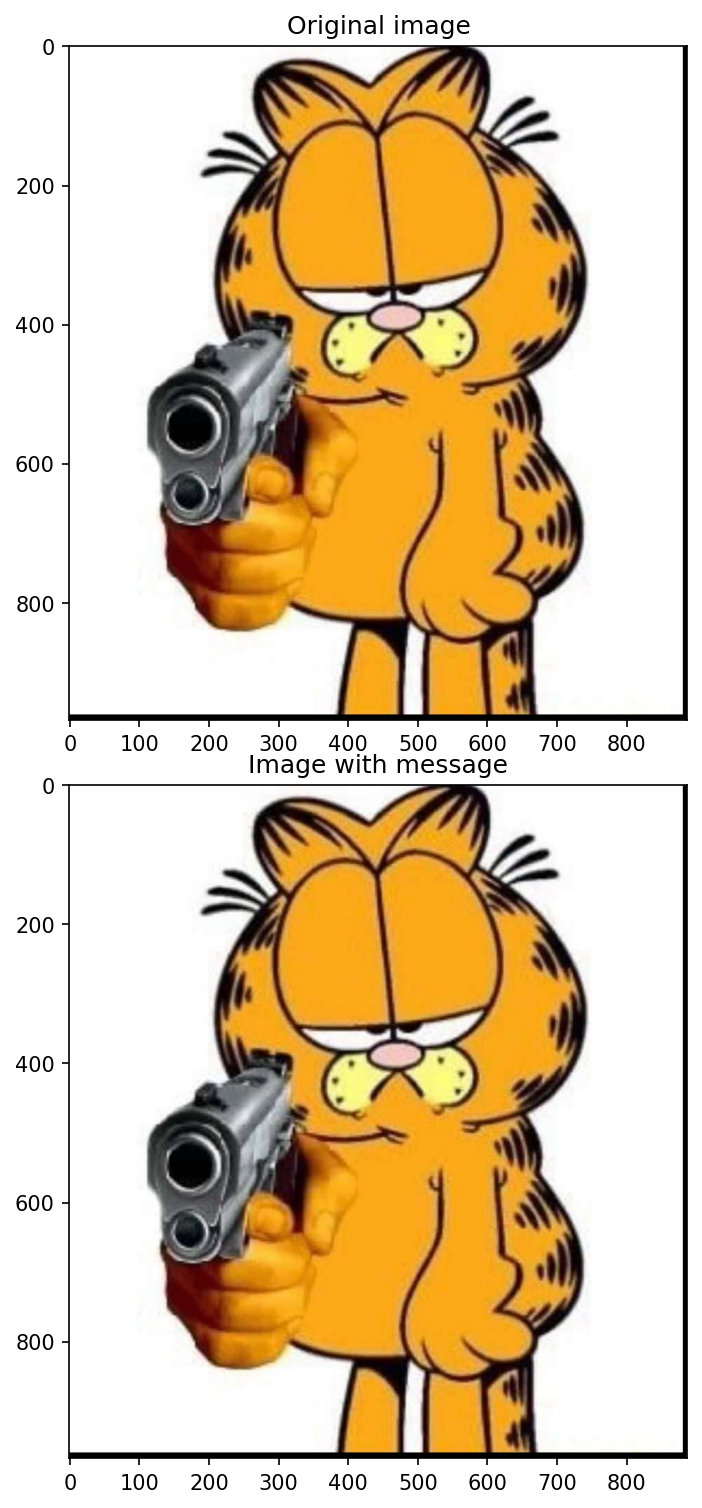

In [16]:
original_image = load_image("images/image0.png", True)
message = "elo elo 350"

n = 1  

message = encode_as_binary_array(message) 
image_with_message = hide_message_n(original_image, message, n)  

save_image("images/image_with_message.png", image_with_message) 

image_with_message_png = load_image("images/image_with_message.png")

secret_message_png = decode_from_binary_array(
    reveal_message_n(image_with_message_png, nbits=n, length=len(message)))  

print(secret_message_png)  

f, ar = plt.subplots(2, dpi=150)
f.tight_layout()
ar[0].imshow(original_image)
ar[0].set_title("Original image")
ar[1].imshow(image_with_message)
ar[1].set_title("Image with message")

# Zadanie 2

MSE for nbits = 1: 0.29211821302595115
MSE for nbits = 2: 0.8283509700176367
MSE for nbits = 3: 2.645780974426808
MSE for nbits = 4: 9.732639676240867
MSE for nbits = 5: 30.238103898966994
MSE for nbits = 6: 103.6040517132779
MSE for nbits = 7: 379.27646526203074
MSE for nbits = 8: 1412.5755161092216


Text(0.5, 1.0, 'MSE for different nbits')

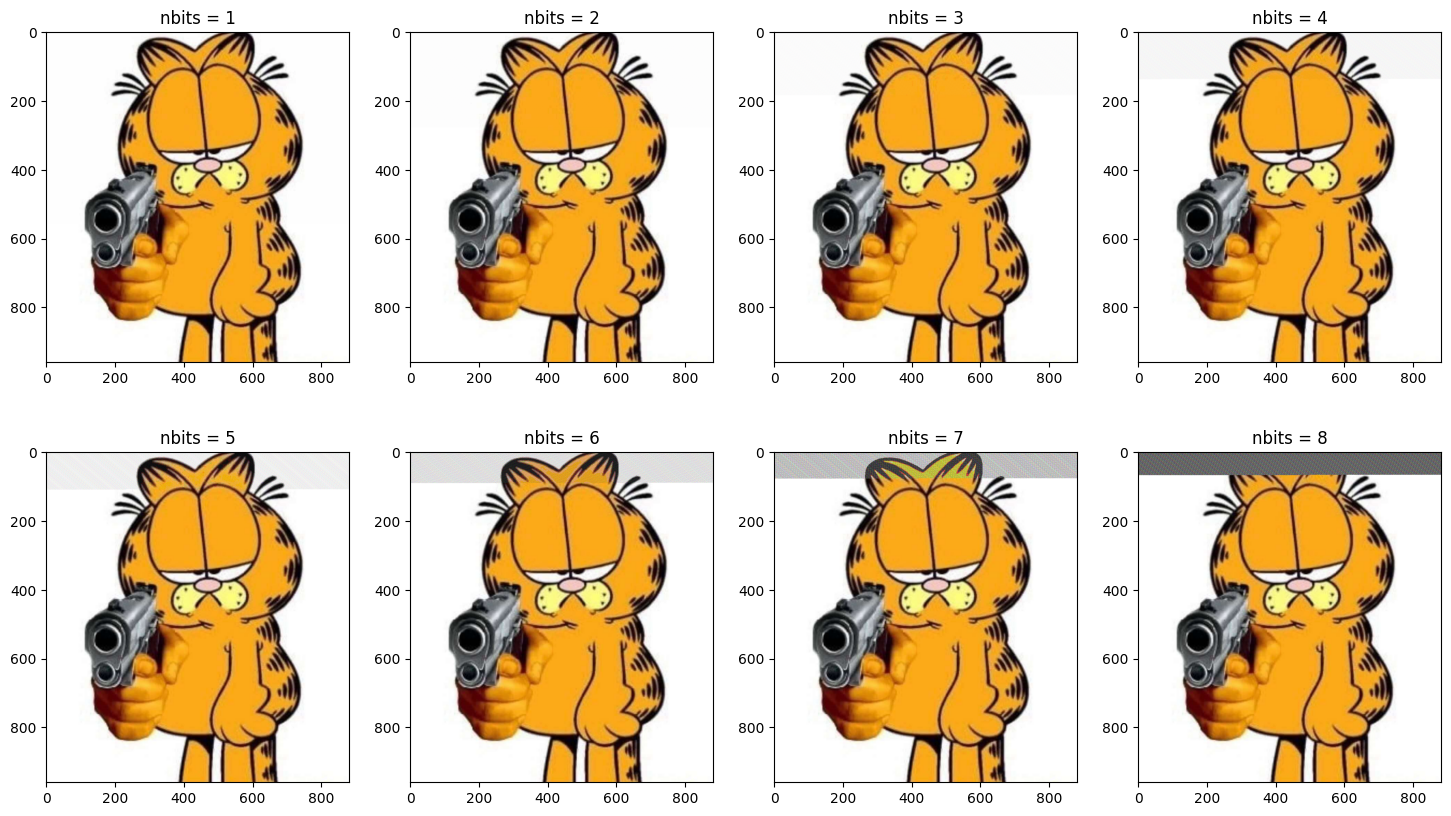

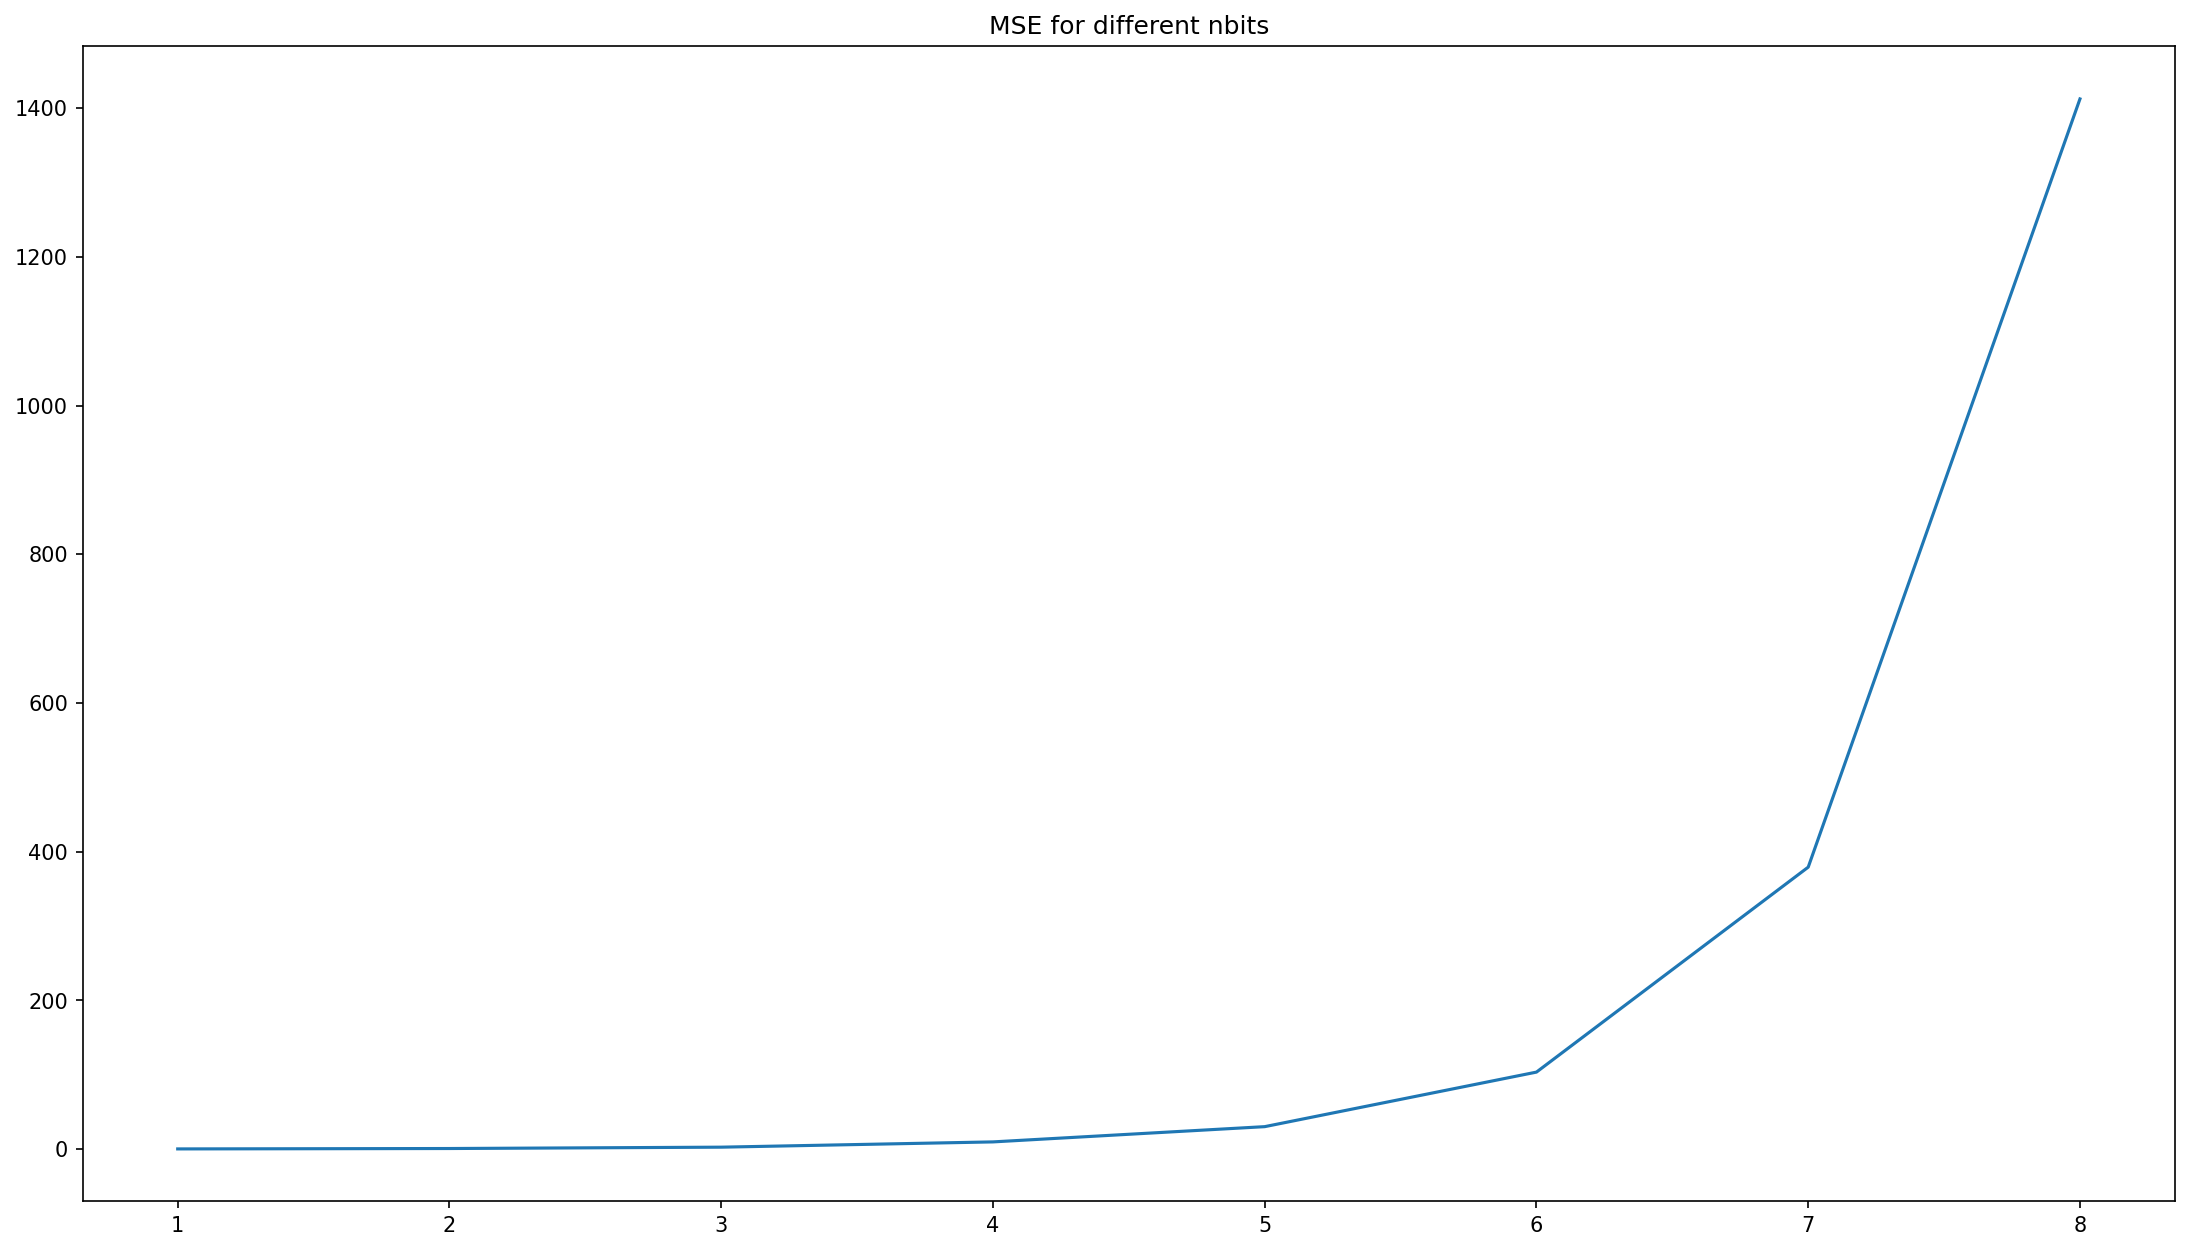

In [17]:
def hide_message(image, message, nbits=1):
    """Hide a message in an image (LSB).
    
    nbits: number of least significant bits
    """
    nbits = clamp(nbits, 1, 8)
    shape = image.shape
    image = np.copy(image).flatten()
    if len(message) > len(image) * nbits:
        raise ValueError("Message is to long :(")
    
    chunks = [message[i:i + nbits] for i in range(0, len(message), nbits)]
    for i, chunk in enumerate(chunks):
        byte = "{:08b}".format(image[i])
        new_byte = byte[:-nbits] + chunk
        image[i] = int(new_byte, 2)
        
    return image.reshape(shape)

def reveal_message(image, nbits=1, length=0):
    """Reveal the hidden message.
    
    nbits: number of least significant bits
    length: length of the message in bits.
    """
    nbits = clamp(nbits, 1, 8)
    shape = image.shape
    image = np.copy(image).flatten()
    length_in_pixels = math.ceil(length/nbits)
    if len(image) < length_in_pixels or length_in_pixels <= 0:
        length_in_pixels = len(image)
    
    message = ""
    i = 0
    while i < length_in_pixels:
        byte = "{:08b}".format(image[i])
        message += byte[-nbits:]
        i += 1
        
    mod = length % -nbits
    if mod != 0:
        message = message[:mod]
    return message


image = load_image("images/image0.png")  # Wczytanie obrazka

message = "Czasie największej rozkoszy w życiu mego narodu - od otwarcia sklepów do ich zamknięcia!" * 2000

images = []

message = encode_as_binary_array(message) 
for nbits in range(1, 9):
    images.append(hide_message(image, message, nbits))


mses = []
for i, message_image in enumerate(images):
    image = np.asarray(image, dtype=np.float64)
    message_image = np.asarray(message_image, dtype=np.float64)
    mse = np.mean((image - message_image) ** 2,  dtype=np.float64)
    mses.append(mse)
    print(f"MSE for nbits = {i + 1}: {mse}")


# Wyświetlenie obrazków
f, ar = plt.subplots(2,4)

for i in range(4):
    for j in range(2):
        ar[j][i].imshow(images[i + j * 4])
        ar[j][i].set_title(f"nbits = {i + j * 4 + 1}")

f, ar = plt.subplots(1, dpi=150)

ar.plot(range(1, 9), mses)
ar.set_title("MSE for different nbits")

# Zadanie 3

In [18]:
def hide_message(image, message, nbits=1, spos=0):
    nbits = clamp(nbits, 1, 8)
    shape = image.shape
    image = np.copy(image).flatten()
    if len(message) > len(image) * nbits:
        raise ValueError("Message is too long :(")
    
    chunks = [message[i:i + nbits] for i in range(0, len(message), nbits)]

    image_first = image[spos:] # tutaj zmieniłem

    for i, chunk in enumerate(chunks):
            byte = "{:08b}".format(image_first[i])
            new_byte = byte[:-nbits] + chunk
            image[i + spos] = int(new_byte, 2)
    
        
    return image.reshape(shape)
def reveal_message(image, nbits=1, length=0, spos=0):
    nbits = clamp(nbits, 1, 8)
    shape = image.shape
    image = np.copy(image).flatten()
    length_in_pixels = math.ceil(length/nbits)
    if len(image) < length_in_pixels or length_in_pixels <= 0:
        length_in_pixels = len(image)
    
    message = ""
    i = spos # i tu 
    while i < length_in_pixels + spos: # i tu
        byte = "{:08b}".format(image[i])
        message += byte[-nbits:]
        i += 1
        
    mod = length % -nbits
    if mod != 0:
        message = message[:mod]
    return message

image = load_image("images/image0.png")  

message = "elo elo"

start_pos = 1000

encoded_message = encode_as_binary_array(message)
image = hide_message(image, encoded_message, 1, start_pos)
message_from_image = reveal_message(image, 1, len(encoded_message),start_pos)
message_from_image = decode_from_binary_array(message_from_image)
print(message_from_image)


elo elo


# Zadanie 4

Text(0.5, 1.0, 'Hidden image')

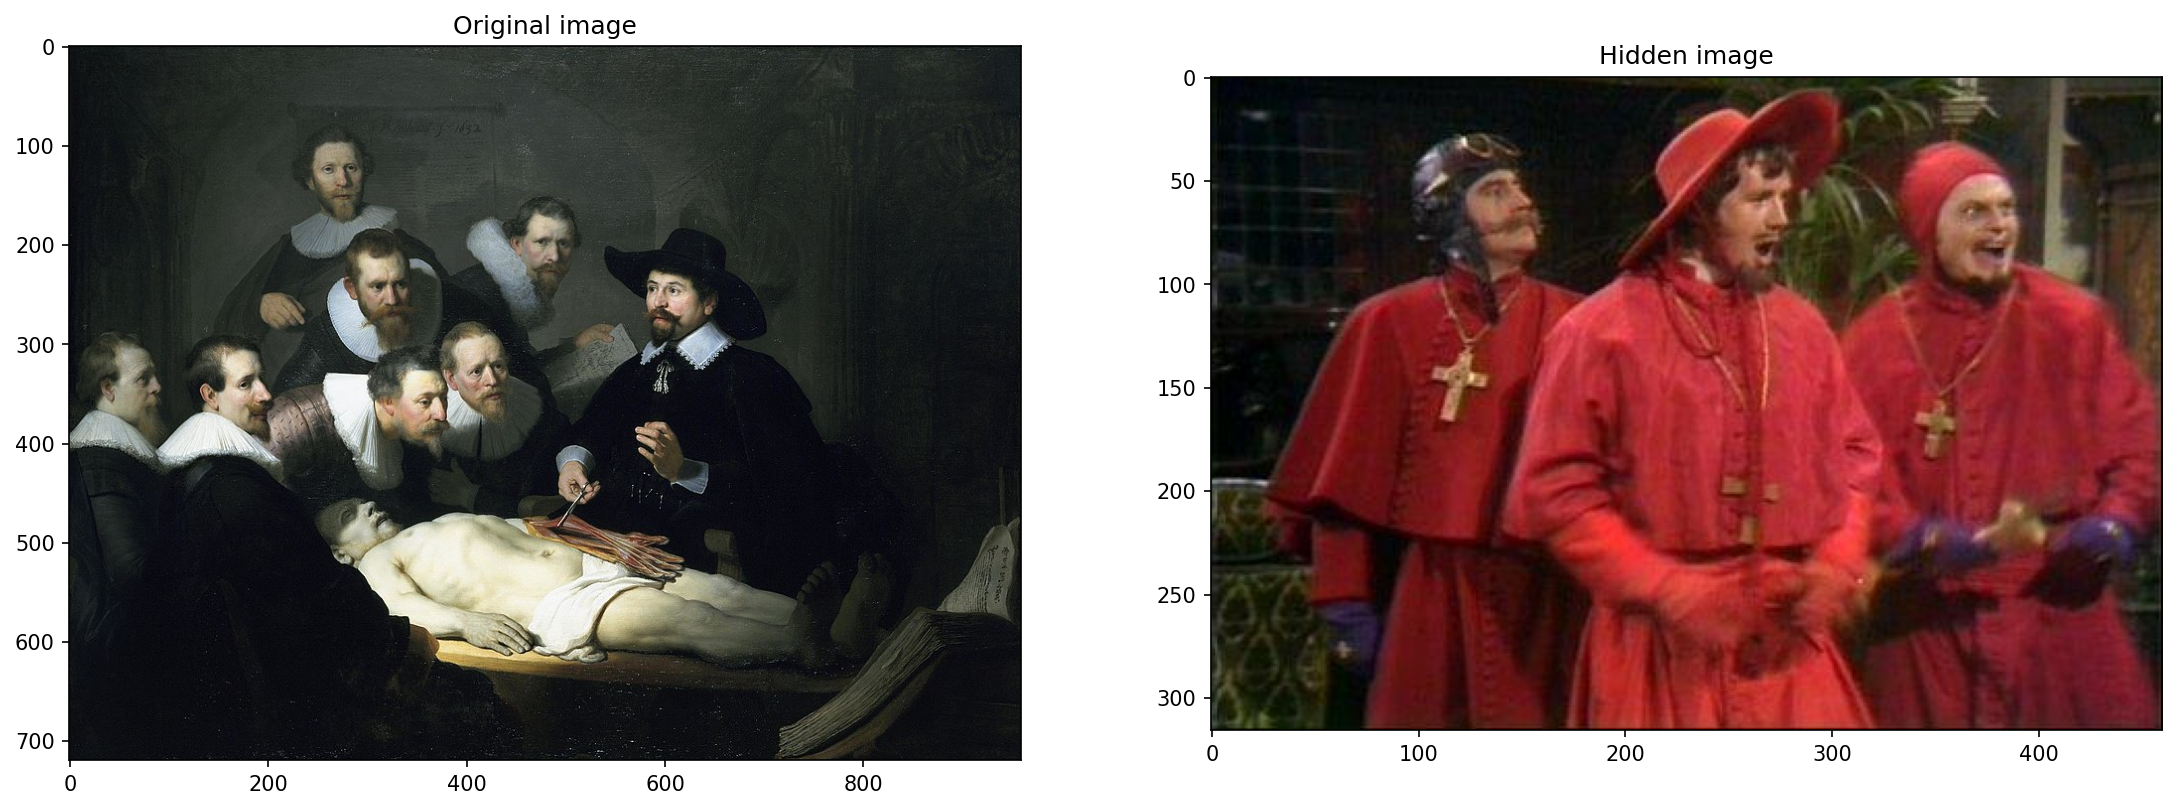

In [19]:
import io


def hide_image(image, secret_image_path, nbits=1):
    with open(secret_image_path, "rb") as file:
        secret_img = file.read()
        
    secret_img = secret_img.hex()
    secret_img = [secret_img[i:i + 2] for i in range(0, len(secret_img), 2)]
    secret_img = ["{:08b}".format(int(el, base=16)) for el in secret_img]
    secret_img = "".join(secret_img)

    return hide_message(image, secret_img, nbits), len(secret_img)

def reveal_hidden_image(image, length, nbits):
    message = reveal_message(image.flatten(), nbits, length)
    
    message_bytes = bytearray()
    for i in range(0, len(message), 8):
        byte = message[i:i+8]
        message_bytes.append(int(byte, 2))

    hidden_image = Image.open(io.BytesIO(message_bytes))
    
    return hidden_image


image = load_image("images/rembrandt.png")
image_with_secret, length_of_secret = hide_image(image, "images/spanish.jpg", 1)


hidden_image = reveal_hidden_image(image_with_secret, length_of_secret, 1)

f, ar = plt.subplots(1, 2, dpi=150)
ar[0].imshow(image)
ar[0].set_title("Original image")
ar[1].imshow(hidden_image)
ar[1].set_title("Hidden image")

# Zadanie 5

Text(0.5, 1.0, 'Hidden image')

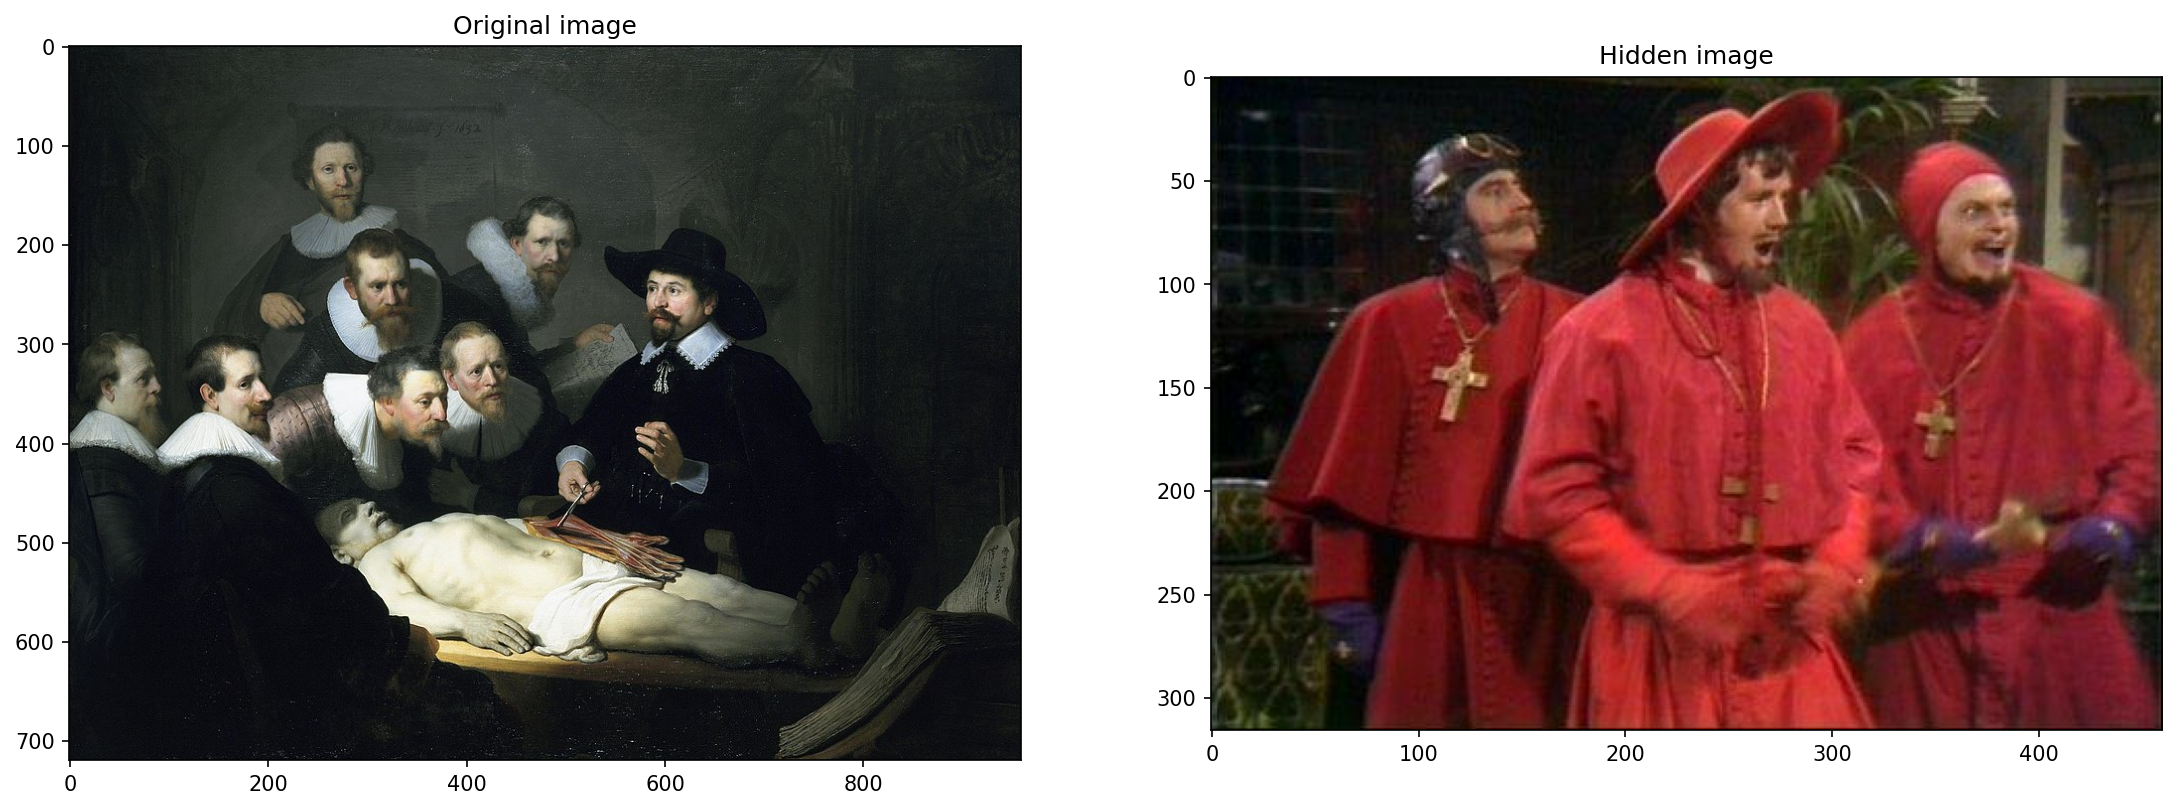

In [20]:
def reveal_message(image, nbits=1, spos=0):
    nbits = clamp(nbits, 1, 8)
    shape = image.shape
    image = np.copy(image).flatten()
    
    footer = b'\xFF\xD9'
    footer_length = len(footer)
    footer_index = -1
    for i in range(len(image) - footer_length + 1):
        if all(image[i + j] == footer[j] for j in range(footer_length)):
            footer_index = i
            break
    
    if footer_index == -1:
        footer_index = len(image)
    
    message = ""
    i = spos
    while i < footer_index:
        byte = "{:08b}".format(image[i])
        message += byte[-nbits:]
        i += 1
        
    mod = len(message) % nbits
    if mod != 0:
        message = message[:-mod]
    return message




def reveal_hidden_image(image, nbits):
    message = reveal_message(image.flatten(), nbits)
    
    message_bytes = bytearray()
    for i in range(0, len(message), 8):
        byte = message[i:i+8]
        message_bytes.append(int(byte, 2))

    hidden_image = Image.open(io.BytesIO(message_bytes))
    
    return hidden_image


image = load_image("images/rembrandt.png")
image_with_secret, length_of_secret = hide_image(image, "images/spanish.jpg", 1)


hidden_image = reveal_hidden_image(image_with_secret, 1)

f, ar = plt.subplots(1, 2, dpi=150)
ar[0].imshow(image)
ar[0].set_title("Original image")
ar[1].imshow(hidden_image)
ar[1].set_title("Hidden image")